In [45]:
# -*- coding: utf-8 -*-
import openmc
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import numpy as np
import pandas as pd

In [46]:
from pathlib import Path
import sys 
CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[2]
sys.path.append(str(project_root))
from src.utils.common.isotope import Radionuclide_lara

In [47]:
df = pd.read_csv("rn.csv", sep=";")
# modify the format of the Radionuclide name : change 54Mn to Mn-54 for example
df["Radionuclide"] = df["Radionuclide"].apply(lambda x: f"{''.join(filter(str.isalpha, x))}-{''.join(filter(str.isdigit, x))}")

In [48]:
dict_rn = df.set_index("Radionuclide").to_dict()["Mass[g]"]


In [49]:
dict_rn

{'Mn-54': 0.0002,
 'Co-58': 0.0003,
 'Co-60': 0.0005,
 'Fe-59': 0.0001,
 'Cr-51': 0.0004,
 'Co-57': 0.0002,
 'Zn-65': 0.0001,
 'Fe-55': 0.0002,
 'Mn-56': 0.0003,
 'Na-22': 0.0001}

In [50]:
def compute_total_source_term(dict_rn, 
                              time:int=0, 
                              unit_energy:str="keV") -> tuple:
    rays = []
    weights = []
    for rn, mass in dict_rn.items():
        rn_lara = Radionuclide_lara(rn)
        energy, intensity, _ = rn_lara.get_rays_emission_data(photon_only=True)
        act = rn_lara.get_activity_after_time(mass=mass, time=time)
        rays.extend(energy)
        weights.extend(intensity * act)
    if unit_energy == "keV":
        pass
    elif unit_energy == "MeV":
        rays = np.array(rays) / 1000
    elif unit_energy == "eV":
        rays = np.array(rays) * 1000
    total_weight = sum(weights)
    return rays, weights, total_weight

Calcul du terme source après 0 seconde

In [51]:
rays, weights, total_weight = compute_total_source_term(dict_rn, time=0, unit_energy="MeV")

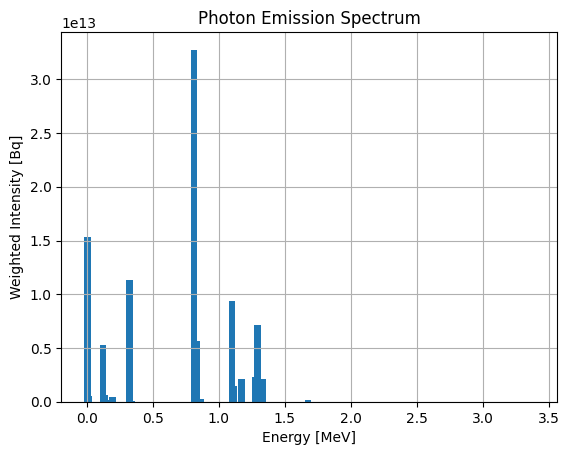

In [61]:
plt.bar(rays, weights, width=0.05)
plt.xlabel("Energy [MeV]")
plt.ylabel("Weighted Intensity [Bq]")
plt.title("Photon Emission Spectrum")
plt.grid(True)
plt.show()

In [53]:
rays, weights, total_weight = compute_total_source_term(dict_rn, time=3600*24*7, unit_energy="MeV")

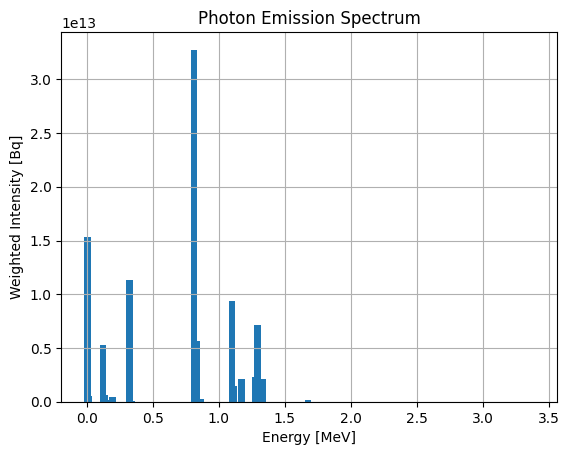

In [60]:
plt.bar(rays, weights, width=0.05)
plt.xlabel("Energy [MeV]")
plt.ylabel("Weighted Intensity [Bq]")
plt.title("Photon Emission Spectrum")
plt.grid(True)
plt.show()

Caclcul of the activity after several points of time

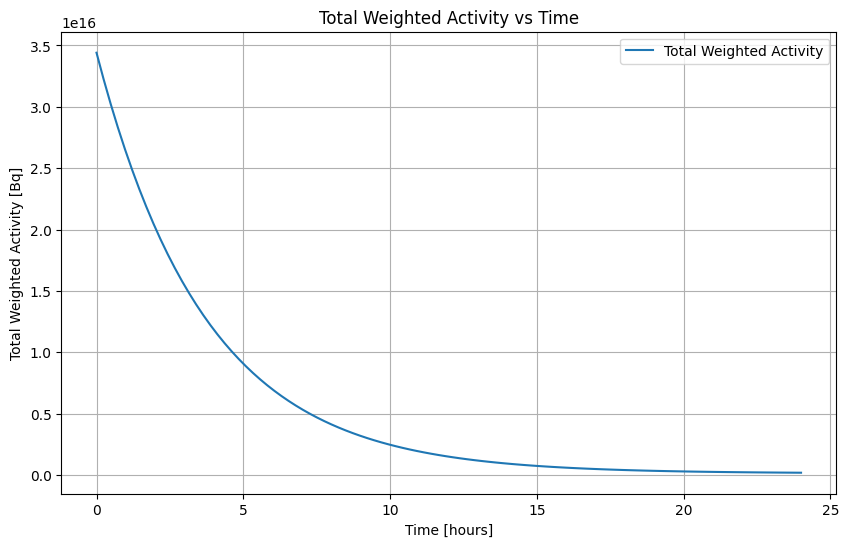

In [55]:
time_points = np.linspace(0, 3600 * 24, 100)  # 1 day in seconds
def compute_total_activity(dict_rn, time_points):
    total_weight_at_time = []
    for time in time_points:
        _, _, total_weight = compute_total_source_term(dict_rn, time=time)
        total_weight_at_time.append(total_weight)
    return total_weight_at_time

total_weight_at_time = compute_total_activity(dict_rn, time_points)

plt.figure(figsize=(10, 6))
plt.plot(time_points / 3600, total_weight_at_time, label="Total Weighted Activity")
plt.xlabel("Time [hours]")
plt.ylabel("Total Weighted Activity [Bq]")
plt.title("Total Weighted Activity vs Time")
plt.legend()
plt.grid(True)
plt.show()

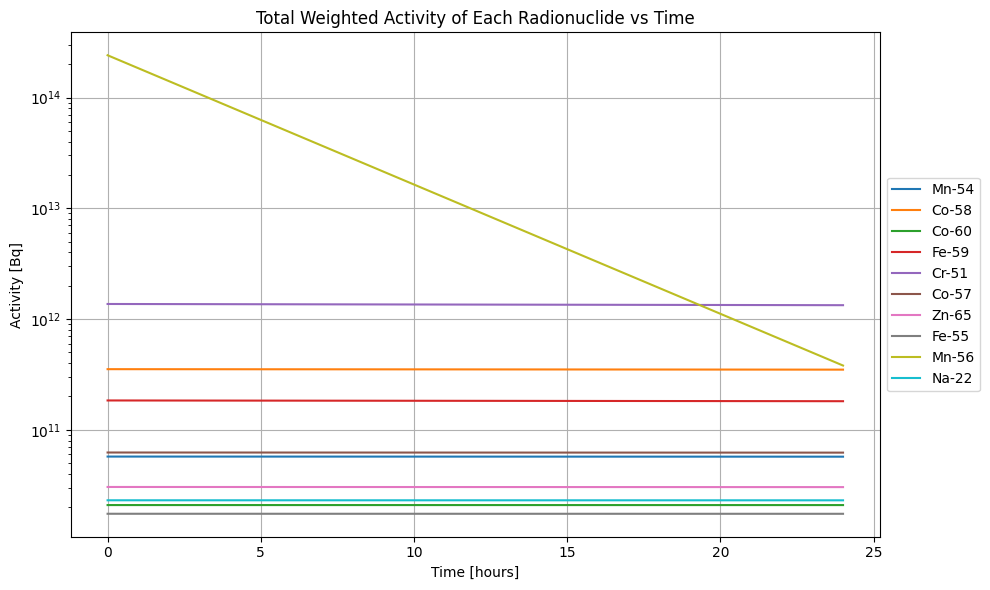

In [56]:
# plot the total weighted activity of every radionuclide vs time
# Calculate and plot the total weighted activity of every radionuclide vs time

time_points = np.linspace(0, 3600 * 24, 100)  # 1 day in seconds
total_weights_per_rn = {}
for rn, mass in dict_rn.items():
    rn_lara = Radionuclide_lara(rn)
    # Compute activity at each time point for this radionuclide
    activities = np.array([rn_lara.get_activity_after_time(mass=mass, time=t) for t in time_points])
    total_weights_per_rn[rn] = activities

plt.figure(figsize=(10, 6))
for rn, activities in total_weights_per_rn.items():
    plt.plot(time_points / (3600), activities, label=rn)
plt.xlabel("Time [hours]")
plt.ylabel("Activity [Bq]")
plt.title("Total Weighted Activity of Each Radionuclide vs Time")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

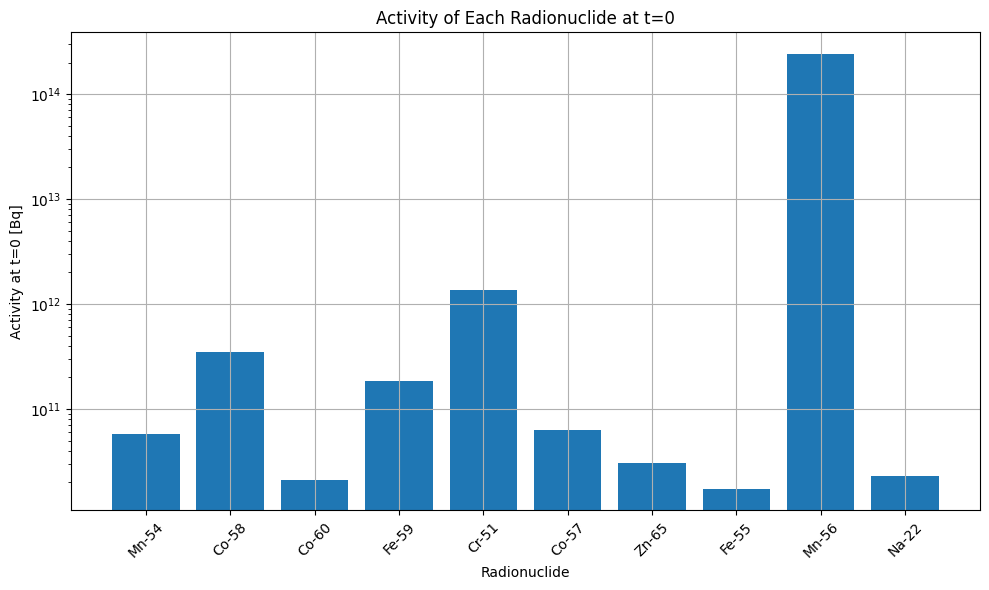

In [57]:
# plot an histogramn of the activity of every radionuclide at t=0

total_weights_per_rn = {}
for rn, mass in dict_rn.items():
    rn_lara = Radionuclide_lara(rn)
    activity_t0 = rn_lara.get_activity_after_time(mass=mass, time=0)
    total_weights_per_rn[rn] = np.array([activity_t0])

activities_at_t0 = {rn: activities[0] for rn, activities in total_weights_per_rn.items()}

plt.figure(figsize=(10, 6))
plt.bar(activities_at_t0.keys(), activities_at_t0.values())
plt.xlabel("Radionuclide")
plt.ylabel("Activity at t=0 [Bq]")
plt.title("Activity of Each Radionuclide at t=0")
plt.yscale("log")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def penalizing_source_term(rays, weights, energy_windows):
    """
    Aggregate rays and weights into specified energy windows.

    Parameters:
        rays (np.ndarray): Array of ray energies.
        weights (list or np.ndarray): Corresponding weights for each ray.
        energy_windows (list of tuple): List of (min_energy, max_energy) tuples defining the windows.

    Returns:
        window_energies (list): Energy of the highest-energy ray in each window.
        window_weights (list): Sum of weights in each window.
    """
    rays = np.array(rays)
    weights = np.array(weights)
    window_energies = []
    window_weights = []
    for (emin, emax) in energy_windows:
        mask = (rays >= emin) & (rays < emax)
        if np.any(mask):
            max_energy = rays[mask].max()
            sum_weight = weights[mask].sum()
            window_energies.append(max_energy)
            window_weights.append(sum_weight)
        else:
            window_energies.append(None)
            window_weights.append(0)
    return window_energies, window_weights

# Example usage:
energy_windows = [(0, 0.1), (0.1, 0.5), (0.5, 1.0), (1.0, 2.0), (2.0, 3.0)]
window_energies, window_weights = penalizing_source_term(rays, weights, energy_windows)
print("Window energies:", window_energies)
print("Window weights:", window_weights)

(array([5.9889000e-04, 5.4055700e-03, 5.4147900e-03, 5.9669000e-03,
        8.3484800e-01, 7.3120000e-04, 6.3909100e-03, 6.4039100e-03,
        7.0832000e-03, 8.1076020e-01, 8.6395800e-01, 1.6747050e+00,
        8.4000000e-04, 7.4609700e-03, 7.4782400e-03, 8.2967000e-03,
        3.4714000e-01, 8.2610000e-01, 1.1732280e+00, 1.3324920e+00,
        2.1585700e+00, 2.5056920e+00, 7.7335000e-04, 6.9153800e-03,
        6.9304000e-03, 7.6777000e-03, 1.4265100e-01, 1.9234900e-01,
        3.3500000e-01, 3.8246000e-01, 1.0992450e+00, 1.2915900e+00,
        1.4817000e+00, 5.3715000e-04, 4.9447000e-03, 4.9522400e-03,
        5.4452000e-03, 3.2008350e-01, 7.0540000e-04, 6.3909100e-03,
        6.4039100e-03, 7.0832000e-03, 1.4412950e-02, 1.2206065e-01,
        1.3647356e-01, 2.3027000e-01, 3.3967000e-01, 3.5234000e-01,
        3.6674000e-01, 5.6994000e-01, 6.9201000e-01, 7.0641500e-01,
        9.1650000e-04, 8.0279200e-03, 8.0478700e-03, 8.9412000e-03,
        3.4495000e-01, 7.7064000e-01, 1.1155390e